# Forecast Trend with Neural Networks

This notebook is an attempt to improve a trend-following strategy using neural networks. The benchmark strategy against which is compared uses simple moving average cross-overs. We will try to see if there are any ways to beat it by utilising neural networks. 

In [1]:
%matplotlib inline
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, 
                                     cross_val_score, GridSearchCV)

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

from adagio.layers.signal import signal_trend_ma_xover
from adagio.utils import keys
from adagio.utils.mongo import get_library

Using TensorFlow backend.


# Load data
Firstly, we load training data from the database which is generated by the package `adagio`. In this notebook, we stick to daily return series of S&P500 futures (1st contract).

In [2]:
library = get_library(keys.backtest)
symbols = library.list_symbols(lo_ticker='CME_ES', nth_contract=1)
item = library.read(symbols[0])
engine = item.data

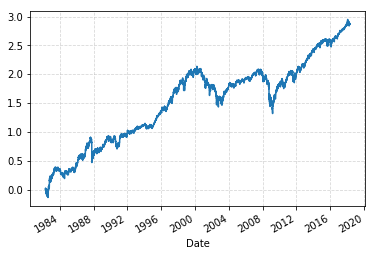

In [3]:
engine.get_final_net_returns().cumsum().plot();

In [4]:
engine.get_final_net_returns().tail()

Date
2018-04-23   -0.000090
2018-04-24   -0.012984
2018-04-25    0.003336
2018-04-26    0.010820
2018-04-27   -0.001082
Name: final_net_returns (engine), dtype: float64

# Pre-processing
## Split data into training and test set

Here simply the first 75% of data is used for training, while the remaining 25% is kept aside as a test set.

In [5]:
return_train, return_test = train_test_split(engine.get_final_net_returns(),
                                             test_size=0.25, shuffle=False, random_state=0)

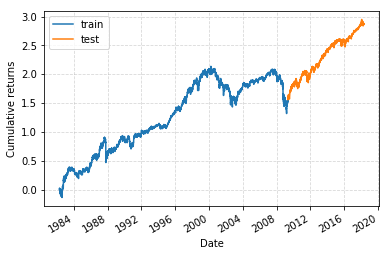

In [6]:
fig, ax = plt.subplots()
pd.concat((return_train.cumsum().rename('train'), 
           return_test.cumsum().add(return_train.cumsum()[-1]).rename('test')), 
          axis=1).plot(ax=ax);
ax.set_ylabel('Cumulative returns');

## Create train and test signal

The basic idea of training here is to use moving average cross-over with different windows to predict subsequent returns.

About training data:
- `x_train`: Moving average cross over with different look-back windows. Signal changes on a daily basis and is computed by the `signal_trend_ma_xover` function. The difference between two moving averages are normalised by the training realised volatility. And thus the signal output by this function can be seen as standard normal (which is not in reality).
- `y_train`: Rolling (future) weekly return. We do not try to predict subsequent daily returns because it's so noisy. Return is also normlaised by the volatility as well.

Test data is also generated with the same methodology but based on the test data set.

In [7]:
signal_common_params = {
    keys.signal_method_params: {
        keys.signal_method: keys.signal_trend_ma_xover,
    },
    keys.signal_to_position: keys.linear
}
signal_windows = [
    [1, 3],
    [2, 6],
    [4, 12],
    [8, 24], 
    [16, 48], 
    [32, 96]
]

def get_x_and_y(data_set):
    data_x = []
    for windows in signal_windows:
        signal_params = deepcopy(signal_common_params)
        signal_params[keys.signal_method_params][keys.signal_windows] = windows

        # trading lag is already implemented
        signal_train = signal_trend_ma_xover(data_set, signal_params)
        signal_train.name = 'short-term: {}, long-term: {}'.format(*windows)
        data_x.append(signal_train)

    data_x = pd.concat(data_x, axis=1)
    
    return_normalised = data_set.div(data_set.ewm(halflife=252).std())
    data_y = return_normalised.rolling(5).sum().shift(-5 + 1)
    
    index_intersection = data_x.dropna().index.intersection(data_y.dropna().index)
    data_x = data_x.reindex(index_intersection)
    data_y = data_y.reindex(index_intersection)
    return data_x, data_y

In [8]:
x_train, y_train = get_x_and_y(return_train)
x_test, y_test = get_x_and_y(return_test)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6863, 6)
(6863,)
(2284, 6)
(2284,)


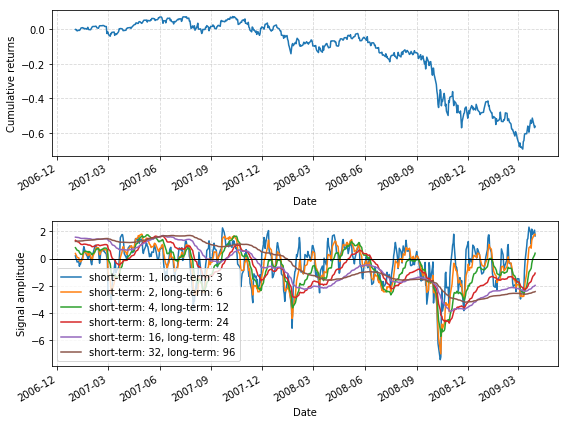

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
return_train['2007':'2009-03'].cumsum().plot(ax=ax[0])
x_train['2007':'2009-03'].plot(ax=ax[1])
ax[0].set_ylabel('Cumulative returns')
ax[1].set_ylabel('Signal amplitude')
ax[1].axhline(0, color='black', lw=1)
fig.tight_layout()

As a benchmark, the chart below shows the performance just based on these cross-overs. Long-term cross-over tends to perform better while short-term did worse. This suggests maybe doing short-term mean reversion + long-term trend-following performs better.

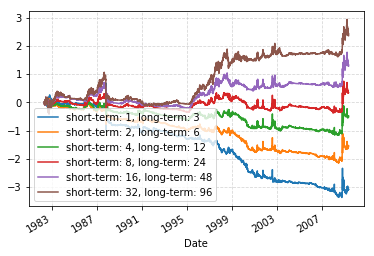

In [11]:
x_train.mul(return_train, axis=0).cumsum().plot();

In [12]:
x_train.describe()

,"short-term: 1, long-term: 3","short-term: 2, long-term: 6","short-term: 4, long-term: 12","short-term: 8, long-term: 24","short-term: 16, long-term: 48","short-term: 32, long-term: 96"
count,6863.000000,6863.000000,6863.000000,6863.000000,6863.000000,6863.000000
mean,0.065891,0.101021,0.155505,0.246714,0.428650,0.791926
std,1.025596,1.051835,1.097132,1.179732,1.312828,1.487606
min,-11.261690,-8.583430,-6.028234,-4.739082,-3.857426,-3.524673
25%,-0.496994,-0.474269,-0.428677,-0.348337,-0.319734,-0.103977
50%,0.152829,0.191952,0.236844,0.311304,0.511601,0.796994
75%,0.720472,0.746714,0.818262,1.000816,1.259310,1.714679
max,3.817000,3.599215,3.035161,3.236624,3.772798,4.011411


# Try neural networks

In this section, we try a very simple architecture with just one hidden layer. We run a grid serach (GridSearchCV) to find an optimal number of units. Cross-validation is done by `TimeSeriesSplit`.

The hyperparameter space that is searched is
- number of units: 5, 10, 20, 50 and 100

In [13]:
def build_fn(units):
    model = Sequential()
    model.add(Dense(units, kernel_initializer='normal', input_dim=6, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(optimizer=Adam(), loss=mean_squared_error)
    return model

def plot_grid_search_cv_result(grid_result):
    params = grid_result.cv_results_['params']
    means = pd.DataFrame(grid_result.cv_results_['mean_test_score'], index=params, columns=['loss'])
    stds = pd.Series(grid_result.cv_results_['std_test_score'], index=params)
    means.plot(kind='barh', xerr=stds)

In [14]:
keras_regressor = KerasRegressor(build_fn=build_fn,
                                 batch_size=10, epochs=100, verbose=0)
time_series_cv = TimeSeriesSplit(n_splits=10)
param_grid = dict(units=[5, 10, 20, 50, 100])
grid = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=time_series_cv,
                    n_jobs=1, return_train_score=True)

In [15]:
grid_result = grid.fit(x_train, y_train)

The chart below shows the cross validation score with different unit sizes. Unfortunately there is not so much difference. Interestingly the less unit size leads to the slightly smaller loss although the difference is within one standard deviation. Furthermore a MSE of 4 is not good at all in the first place (very roughly speaking `y` is drawn from standard normal).

Note that the loss in the figure below is negated by `GridSearchCV`.

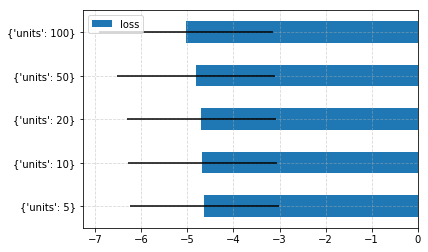

In [16]:
plot_grid_search_cv_result(grid_result)

# Backtest using the best model

Just for fun, here's the training result using the best model.

In [17]:
best_model = build_fn(5)

In [18]:
result = best_model.fit(x_train, y_train, batch_size=10, epochs=100, verbose=0)

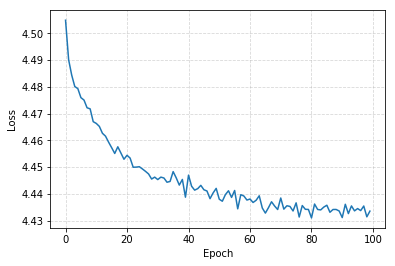

In [19]:
fig, ax = plt.subplots()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.plot(result.epoch, result.history["loss"]);

Of cource this model almost certainly overfit the training model. 
The model generally yielded stable returns during normal market environment. However it could have not avoided Black Monday in 1987, which may be a good sign because it would be very challenging to predit based on just historical prices at that time.

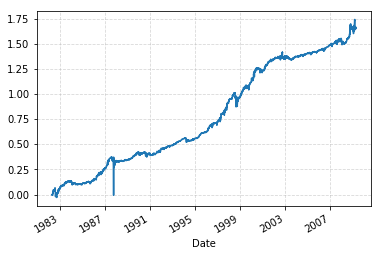

In [20]:
(pd.DataFrame(best_model.predict(x_train), index=x_train.index).squeeze()
 .mul(return_train, axis=0).cumsum().plot());

We will not use the test data until we get a reasonable training result...